# Tweedie Regression

In insurance premium prediction problems, the total claim amount for a covered risk usually has a continuous distribution on positive values, except for the possibility of being exact zero when the claim does not occur. One standard approach in actuarial science in modeling such data is using compound Poisson models.

##### Compound Poisson distribution

Let $ N $ be a random variable with Poisson distribution and $ Z_1, Z_2, ... $ be independent identically distributed random variables with Gamma distribution. Define a random variable $ Z $ by

$$ Z = \begin{cases}0, & \mbox{if}\ N = 0\\Z_1 + Z_2 + ... + Z_N, & \mbox{if}\ N > 0\end{cases} $$

The resulting distribution of $ Z $ is called compound Poisson distribution. In the case of insurance premium prediction $ N $ referres to the number of claims, $ Z_i $ reffers to the amount of $i$-th claim. Compound Poisson distribution is a special case of Tweedie model.

Log-likelihood of compound Poisson distribution can be written as
$$ p(z) = \frac{1}{\phi}\left(z \frac{\mu^{1-\rho}}{1-\rho} - \frac{\mu^{2-\rho}}{2-\rho}\right) + a$$

where $ a, \phi, \mu $ and $ 1 < \rho < 2 $ are some constants.

We will apply Tweedie model to an auto insurance claim dataset analyzed in Yip, Yau (2005) and Zhou, Yang, Qian (2019).

##### Loading dataset

In [ ]:
!wget https://cran.r-project.org/src/contrib/cplm_0.7-8.tar.gz

In [ ]:
!tar -xf cplm_0.7-8.tar.gz

In [ ]:
!pip install rdata

In [1]:
import warnings
warnings.filterwarnings('ignore')

import rdata

data = rdata.parser.parse_file('cplm/data/AutoClaim.RData')
df = rdata.conversion.convert(data)['AutoClaim']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost.utils import eval_metric
from catboost import CatBoostRegressor, Pool

In [3]:
features = ['AGE', 'BLUEBOOK', 'HOMEKIDS', 'KIDSDRIV', 'MVR_PTS', 
            'NPOLICY', 'RETAINED', 'TRAVTIME', 'AREA', 'CAR_USE', 
            'CAR_TYPE', 'GENDER', 'JOBCLASS', 'MAX_EDUC', 'MARRIED', 
            'REVOLKED']
cat_features = ['AREA', 'CAR_USE', 'CAR_TYPE', 'GENDER', 'JOBCLASS', 
                'MAX_EDUC', 'MARRIED', 'REVOLKED']
target = 'CLM_AMT5'
df = df[features + [target]]
df_train, df_test = train_test_split(df, random_state=0)

df_train.head()

,AGE,BLUEBOOK,HOMEKIDS,KIDSDRIV,MVR_PTS,NPOLICY,RETAINED,TRAVTIME,AREA,CAR_USE,CAR_TYPE,GENDER,JOBCLASS,MAX_EDUC,MARRIED,REVOLKED,CLM_AMT5
1019,45,14830,2,0,0,3,6,31,Urban,Private,Sedan,M,Professional,Masters,Yes,No,0
5461,42,13770,3,1,0,1,14,24,Urban,Private,Sports Car,F,Professional,Bachelors,Yes,No,0
7226,55,21520,0,0,4,1,1,25,Urban,Private,Van,M,Blue Collar,<High School,No,No,6656
6233,33,25380,0,0,0,2,6,27,Urban,Commercial,Panel Truck,M,Blue Collar,High School,No,No,0
8215,45,22680,0,0,5,1,6,24,Urban,Private,Sedan,M,Professional,Masters,No,No,6314


The dataset contains various features describing drivers and their vehicles. The CLM_AMT5 column contains the total claim amount over last 5 years. It will be our target. The following histogram shows distribution of the target.

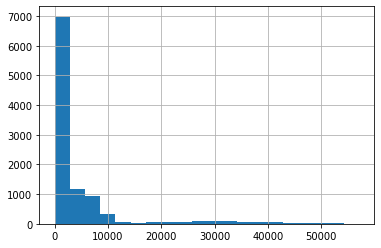

In [4]:
_ = df[target].hist(bins=20)

We see that the distribution has a point mass at 0 and is right skewed. So the use of Tweedie model is well justified.

#### Tweedie loss

For computational stability instead of optimizing $ \mu $ parameter of Tweedie distribution directly, we will optimize $ \log{\mu} $. So the Tweedie loss is given by the following formula:
$$L = \sum_{i=1}^n w_i \left(-\frac{y_i \exp{(F(x_i)(1-\rho))}}{1 - \rho} + \frac{\exp{(F(x_i)(2-\rho))}}{2 - \rho}\right) $$
where $ w_i $ are object weights, $y_i$ is target, $ F(x_i) $ is current object prediction, $\rho $ is the obligatory hyperparameter variance power. Variance power must belong to the interval $ (1, 2) $. 

#### Fitting the model

We will train two CatBoostRegressor models: one trained with Tweedie loss, the other one with RMSE loss. The features are remained unchanged, the categorical ones are specified in Pool's cat_features parameter.

In [5]:
train_pool = Pool(df_train[features], label=df_train[target],
                  cat_features=cat_features)
test_pool = Pool(df_test[features], label=df_test[target],
                 cat_features=cat_features)

cb_tweedie = CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', n_estimators=500, silent=True)
cb_tweedie.fit(train_pool, eval_set=test_pool)

cb_rmse = CatBoostRegressor(loss_function='RMSE', n_estimators=500, silent=True)
cb_rmse.fit(train_pool, eval_set=test_pool)

#### Evaluating the models

We will use MSLE as evaluation metric as it works well with quantities that have exponential growth.

In [6]:
cb_rmse_pred = np.clip(cb_rmse.predict(test_pool), 0, None)
cb_tweedie_pred = cb_tweedie.predict(test_pool)

In [7]:
print('MSLE score:')
print('\ttweedie loss\t', eval_metric(df_test[target].to_numpy(), cb_tweedie_pred, 'MSLE'))
print('\trmse loss\t', eval_metric(df_test[target].to_numpy(), cb_rmse_pred, 'MSLE'))

MSLE score:
	tweedie loss	 [31.676911817518143]
	rmse loss	 [35.72356239317701]


We see that the model trained with Tweedie loss outperforms the model trained with RMSE loss.

#### References
- He Zhou, Yi Yang, Wei Qian (2019), "Tweedie Gradient Boosting for Extremely Unbalanced Zero-inflated Data", *arxiv preprint, [arXiv:1811.10192](https://arxiv.org/abs/1811.10192)*
- Yip, K. C. and Yau, K. K. (2005), "On modeling claim frequency data in general insurance with extra zeros", *Insurance: Mathematics and Economics*, 36, 153–163.